In [12]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from hydra import initialize, compose
from glob import glob

from pandeia.engine.calc_utils import build_default_calc, build_default_source
from pandeia.engine.perform_calculation import perform_calculation

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import overplot, plot, plot_util
from mejiro.lenses import test
from mejiro.helpers import pyhalo, lenstronomy_sim, pandeia_input, convert, bkg
from mejiro.utils import util

In [2]:
lens = test.TutorialLens()
model = lens.get_array(num_pix=45, side=4.95)

In [3]:
noise_list = []

for i in range(10):
    calc = build_default_calc('roman', 'wfi', 'imaging')
    calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.

    # set scene size settings
    calc['configuration']['max_scene_size'] = 5

    # set instrument
    calc['configuration']['instrument']['filter'] = 'f184'  # e.g. 'f106'

    # set detector
    calc['configuration']['detector']['ma_table_name'] = 'hlwas_imaging'

    # turn off noise sources
    calc['calculation'] = pandeia_input.get_calculation_dict(init=False)

    # set background
    calc['background'] = bkg.get_background(suppress_output=False)

    # add an extra point source far out to force maximum scene size
    calc['scene'].append(build_default_source(geometry='point', telescope='roman'))
    calc['scene'][1]['position']['x_offset'] = 100
    calc['scene'][1]['position']['y_offset'] = 100

    image, _ = pandeia_input.get_pandeia_image(calc)
    noise_list.append(image)

RA: 32.296668201762124, DEC: -22.35422883575629
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
RA: 27.54720909437448, DEC: -26.557733545879614
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:00
RA: 31.13607158790807, DEC: -42.715098348709844
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
RA: 20.983223868598525, DEC: -33.21019563898845
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:00
RA: 31.987165401142928, DEC: -30.441648974406462
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
RA: 43.952342774739925, DEC: -36.61313407189974
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:00
RA: 17.861798280377194, DEC: -38.05981699231563
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
RA: 18.983368321508056, DEC: -43.13250057655275
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:00
RA: 30.33720779236606, 

In [4]:
last_array = noise_list[-1]

for i, array in enumerate(noise_list):
    print(np.count_nonzero(last_array - array))

2025
2025
2025
2025
2025
2025
2025
2025
2025
0


In [6]:
last_array = noise_list[-1]
residual_list = [i - last_array for i in noise_list[:-1]]

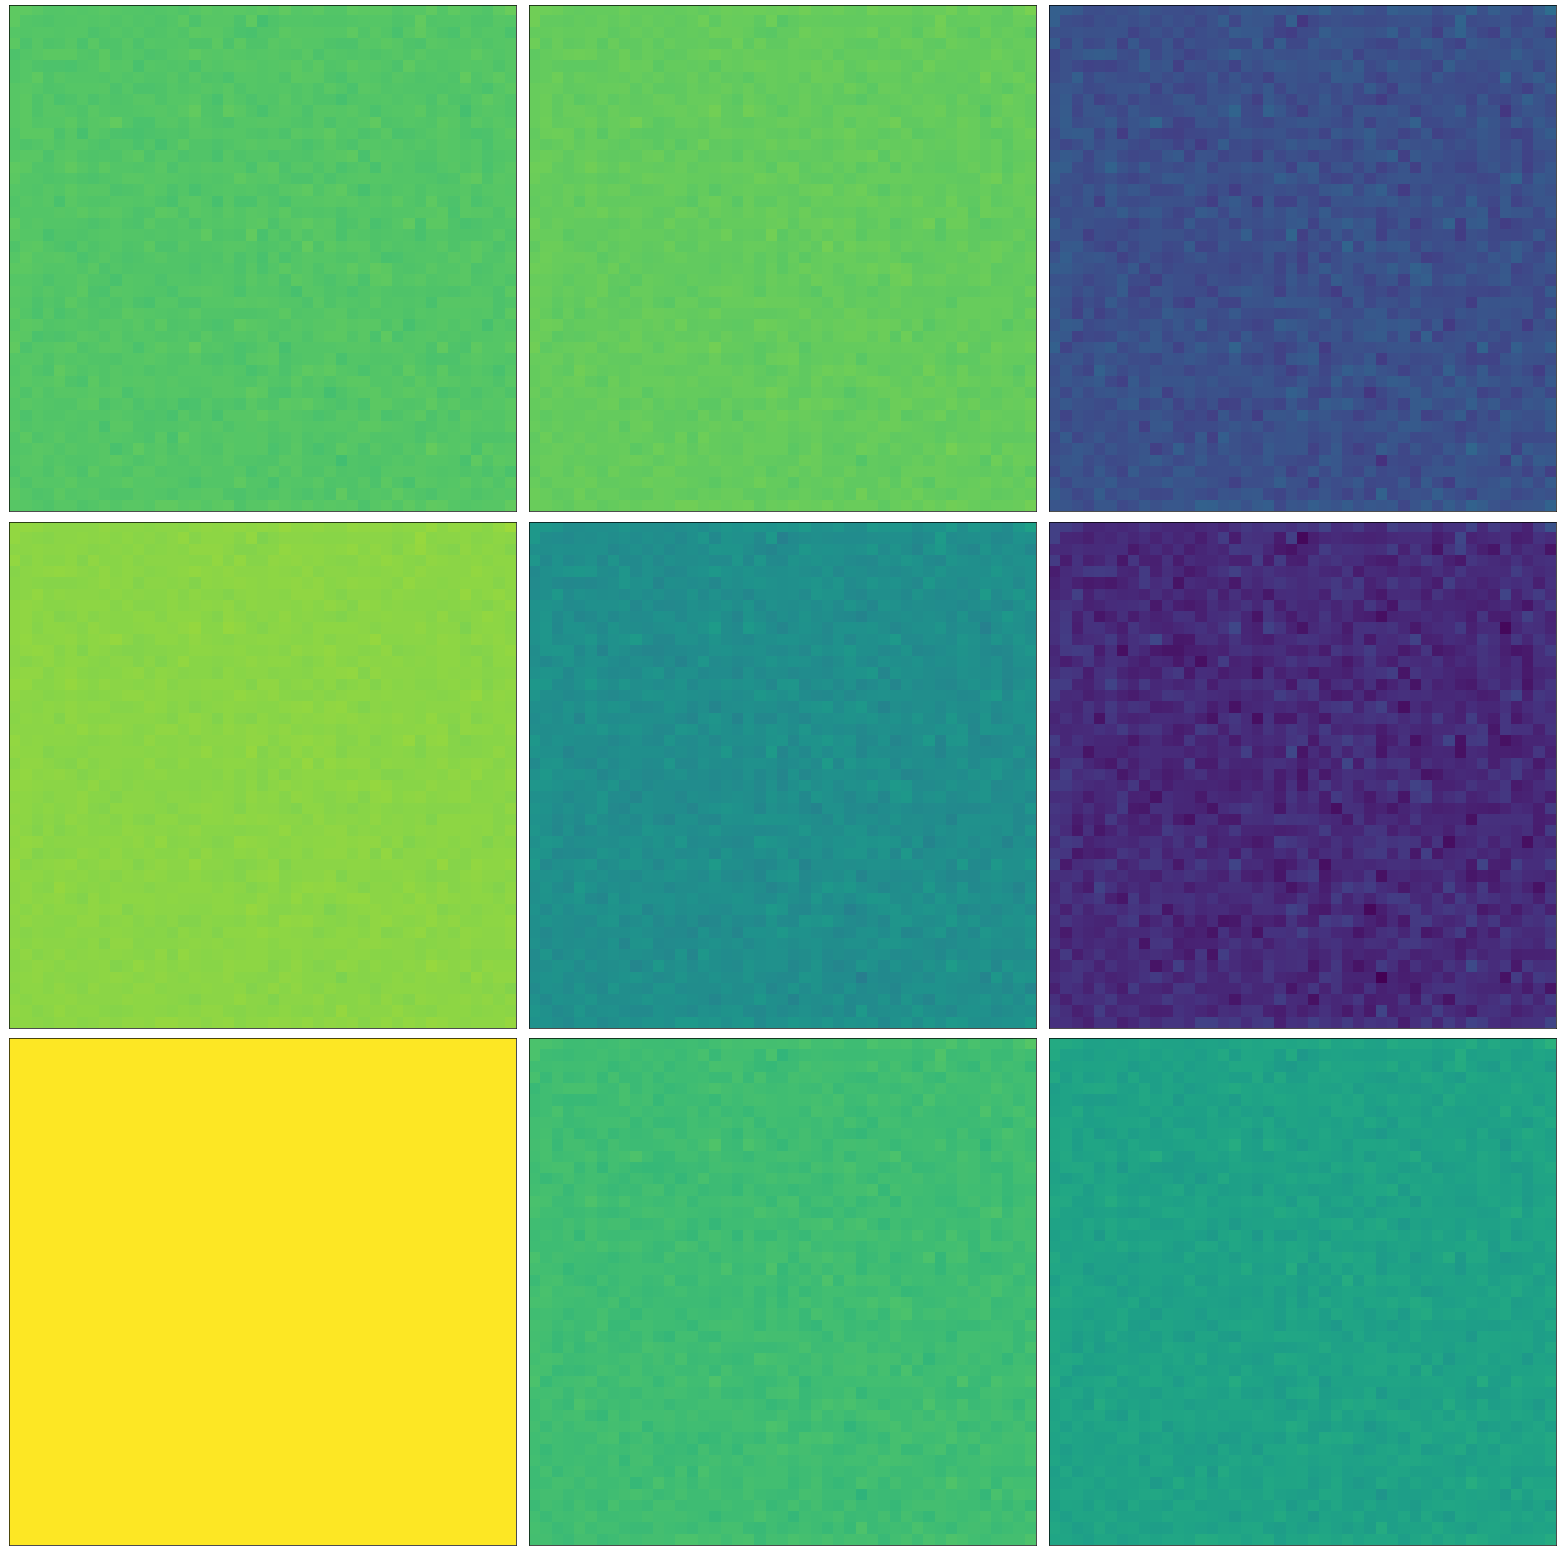

In [7]:
save_path = os.path.join(figure_dir, 'jwst_noise_residuals.png')
plot.plot_grid(residual_list, side=3, log10=False, colorbar=True, save=save_path)

In [28]:
array_list = noise_list
colorbar=True
side=3
cmap='viridis'
log10=False

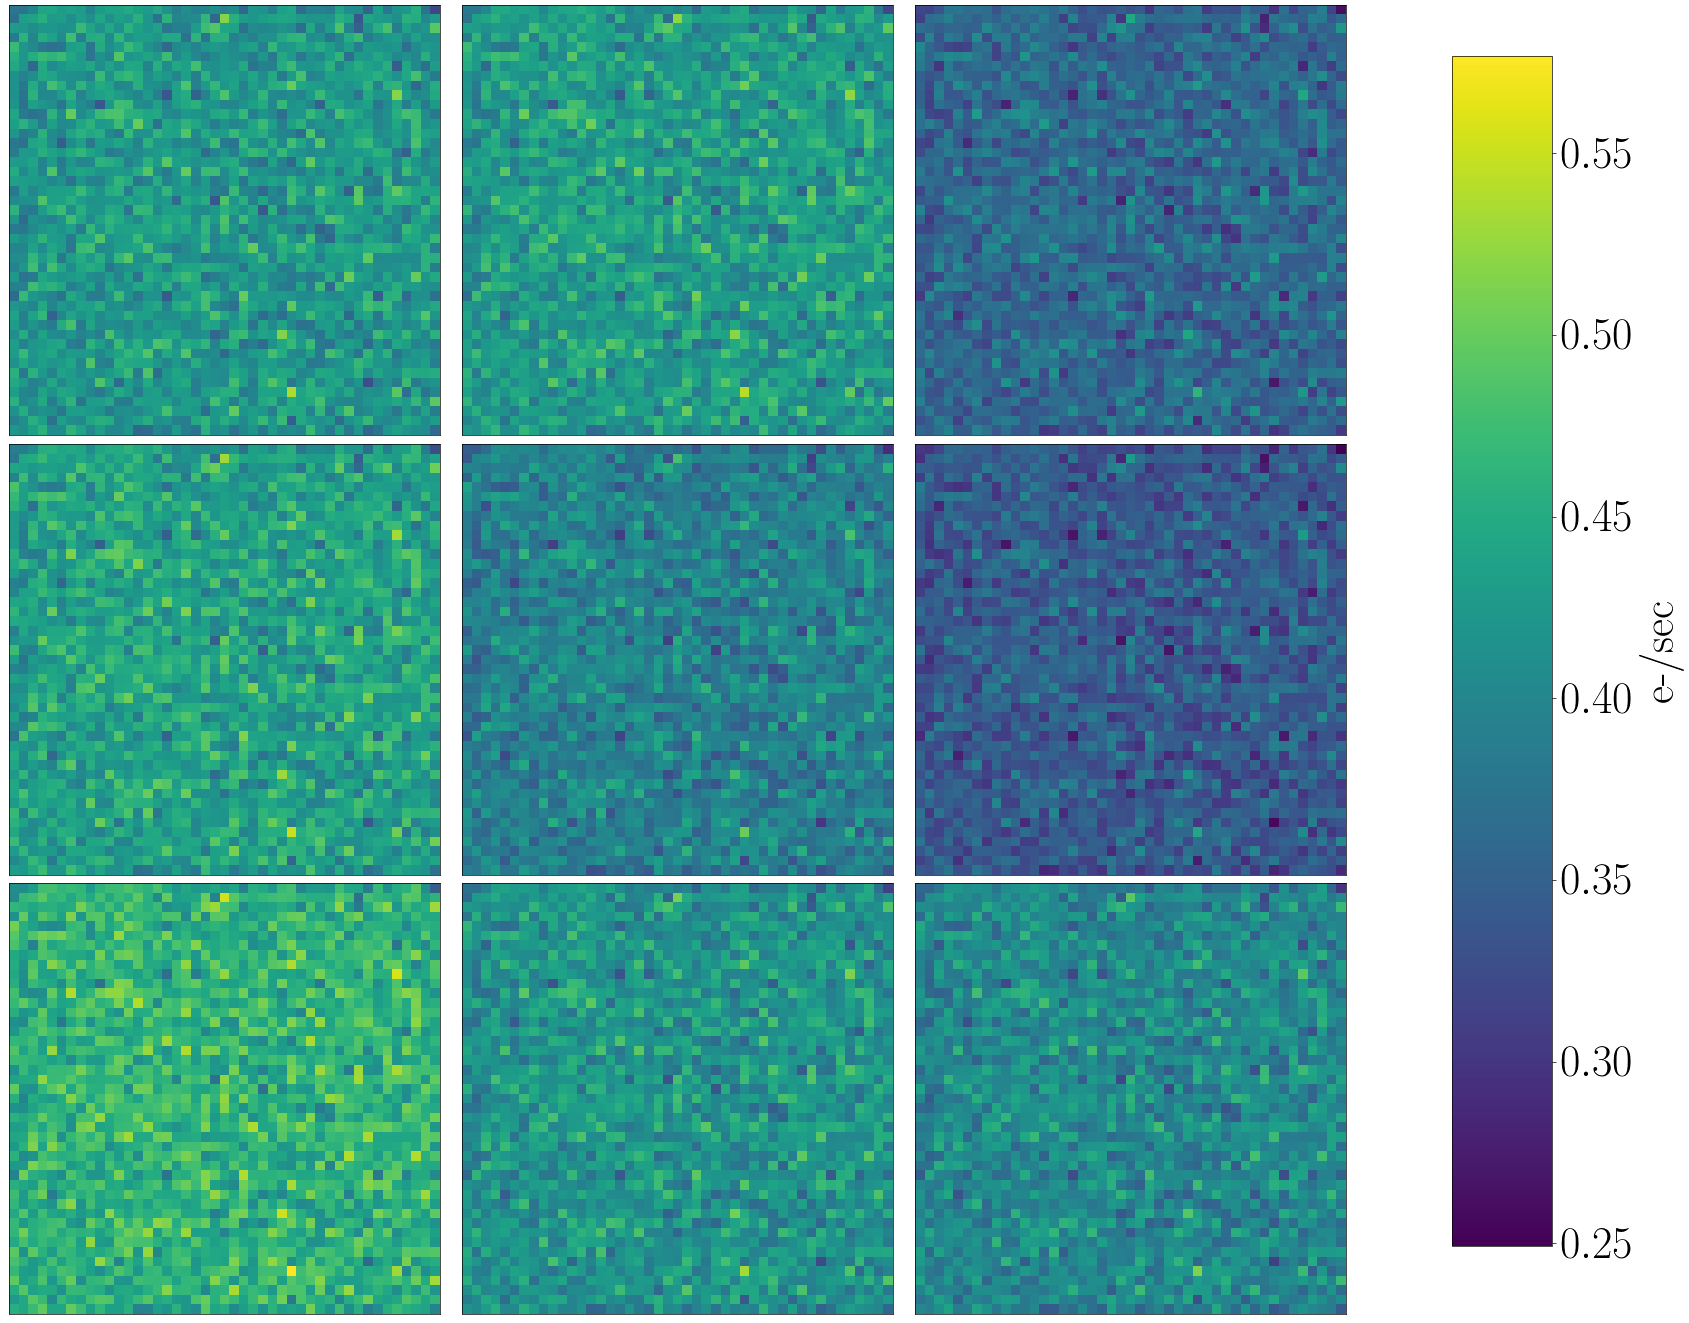

In [42]:
fontsize = 32
import matplotlib
matplotlib.rcParams.update({'font.size': fontsize})

array_list = array_list[:side ** 2]
if colorbar:
    vmin, vmax = plot_util.get_min_max(array_list)

fig, ax = plt.subplots(nrows=side, ncols=side, figsize=(20, 17), gridspec_kw={'hspace': 0.02, 'wspace': 0.02})

for i, image in enumerate(array_list):
    if log10:
        image = np.log10(image)
    if colorbar:
        axis = ax[i // side, i % side].imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        axis = ax[i // side, i % side].imshow(image, cmap=cmap)
    ax[i // side, i % side].get_xaxis().set_visible(False)
    ax[i // side, i % side].get_yaxis().set_visible(False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(axis, cax=cbar_ax)
cbar.set_label('e-/sec', rotation=90)

save_path = os.path.join(figure_dir, 'jwst_noise.png')
plt.savefig(save_path)
plt.show()